## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
# Unzip files
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_1.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_2.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_3.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_4.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_5.tar.gz

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-5fold-roberta-64-clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training set samples: {len(k_fold)}')
display(k_fold.head())

Training set samples: 26882


,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,validation,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 64,
  'BATCH_SIZE': 32,
  'EPOCHS': 7,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 2,
  'N_FOLDS': 5,
  'question_size': 4,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 1e-07 to 2.96e-05 to 1e-06


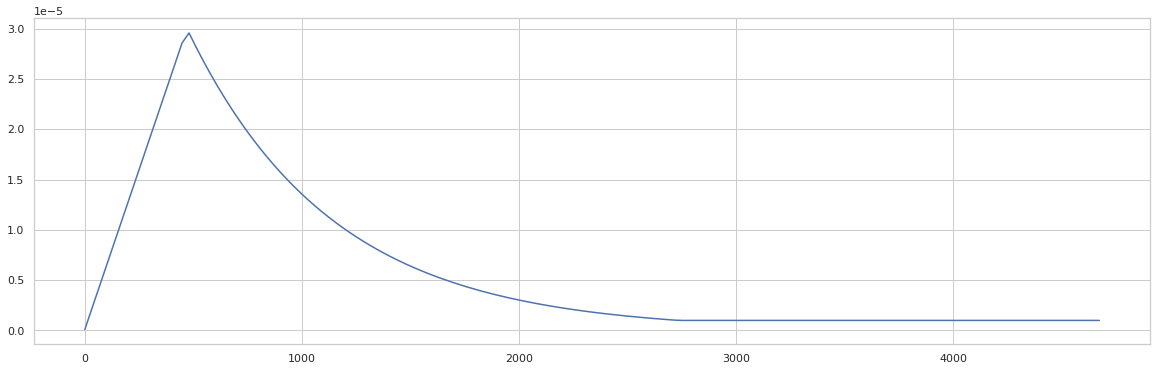

In [6]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = total_steps * 0.1
decay = .9985

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h08 = hidden_states[-5]
    h11 = hidden_states[-2]

    x_mask = layers.Dropout(.1)(h08)    
    mask_logits = layers.Dense(1, name="mask_logit", use_bias=False)(x_mask)
    mask_logits = layers.Flatten()(mask_logits)
    
    x = layers.Dropout(.1)(h11)
    
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(x)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(x)
    end_logits = layers.Flatten()(end_logits)
    

    mask_probs = layers.Activation('sigmoid', name='y_mask')(mask_logits)
    start_probs = layers.Activation('softmax', name='y_start')(start_logits)
    end_probs = layers.Activation('softmax', name='y_end')(end_logits)

    model = Model(inputs=[input_ids, attention_mask], outputs=[start_probs, end_probs, mask_probs])
    
    return model

# Train

In [8]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1]}, 
                                                  {'y_start': y_train[0], 'y_end': y_train[1], 'y_mask': y_train[2]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1]}, 
                                                  {'y_start': y_valid[0], 'y_end': y_valid[1], 'y_mask': y_valid[2]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    y_train_mask = np.load(base_data_path + 'y_train_mask.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    y_valid_mask = np.load(base_data_path + 'y_valid_mask.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=warmup_steps, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_end': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_mask': losses.BinaryCrossentropy(label_smoothing=0.2)})
    
    history = model.fit(get_training_dataset(x_train, (*y_train, y_train_mask), config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, (*y_valid, y_valid_mask), config['BATCH_SIZE'], AUTO, repeated=False, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)

    # Make predictions
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train for 672 steps, validate for 168 steps
Epoch 1/7
672/672 - 176s - loss: 5.3627 - y_start_loss: 2.4047 - y_end_loss: 2.5021 - y_mask_loss: 0.4558 - val_loss: 4.3028 - val_y_start_loss: 1.9622 - val_y_end_loss: 1.9584 - val_y_mask_loss: 0.3822
Epoch 2/7
672/672 - 164s - loss: 4.3109 - y_start_loss: 1.9504 - y_end_loss: 1.9761 - y_mask_loss: 0.3845 - val_loss: 4.2236 - val_y_start_loss: 1.9352 - val_y_end_loss: 1.9098 - val_y_mask_loss: 0.3786
Epoch 3/7
672/672 - 164s - loss: 4.1992 - y_start_loss: 1.9019 - y_end_loss: 1.9154 - y_mask_loss: 0.3818 - val_loss: 4.2004 - val_y_start_loss: 1.9244 - val_y_end_loss: 1.8986 - val_y_mask_loss: 0.3774
Epoch 4/7
672/672 - 163s - loss: 4.1536 - y_start_loss: 1.8861 - y_end_loss: 1.8869 - y_mask_loss: 0.3806 - val_loss: 4.1939 - val_y_start_loss: 1.9223 - val_y_end_loss: 1.8946 - val_y_mask_loss: 0.3770
Epoch 5/7
672/672 - 163s - loss: 4.1320 - y_start_loss: 1.8741 - y_end_loss: 1.8779 - y_mask_loss: 0.3800 - val_loss: 4.1888 - val_y_st

# Model loss graph

Fold: 1


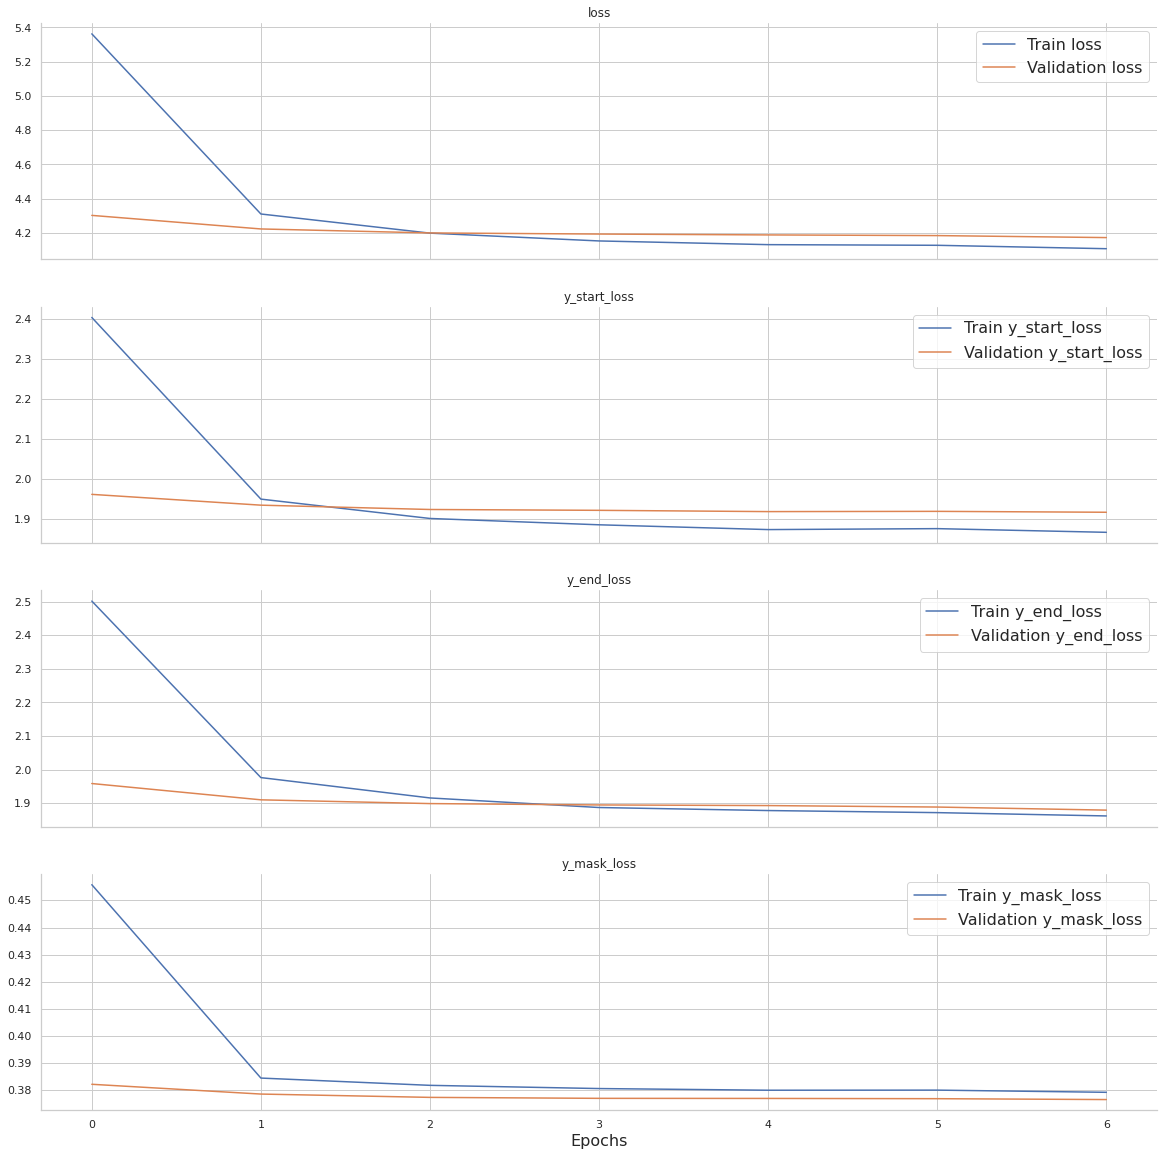

Fold: 2


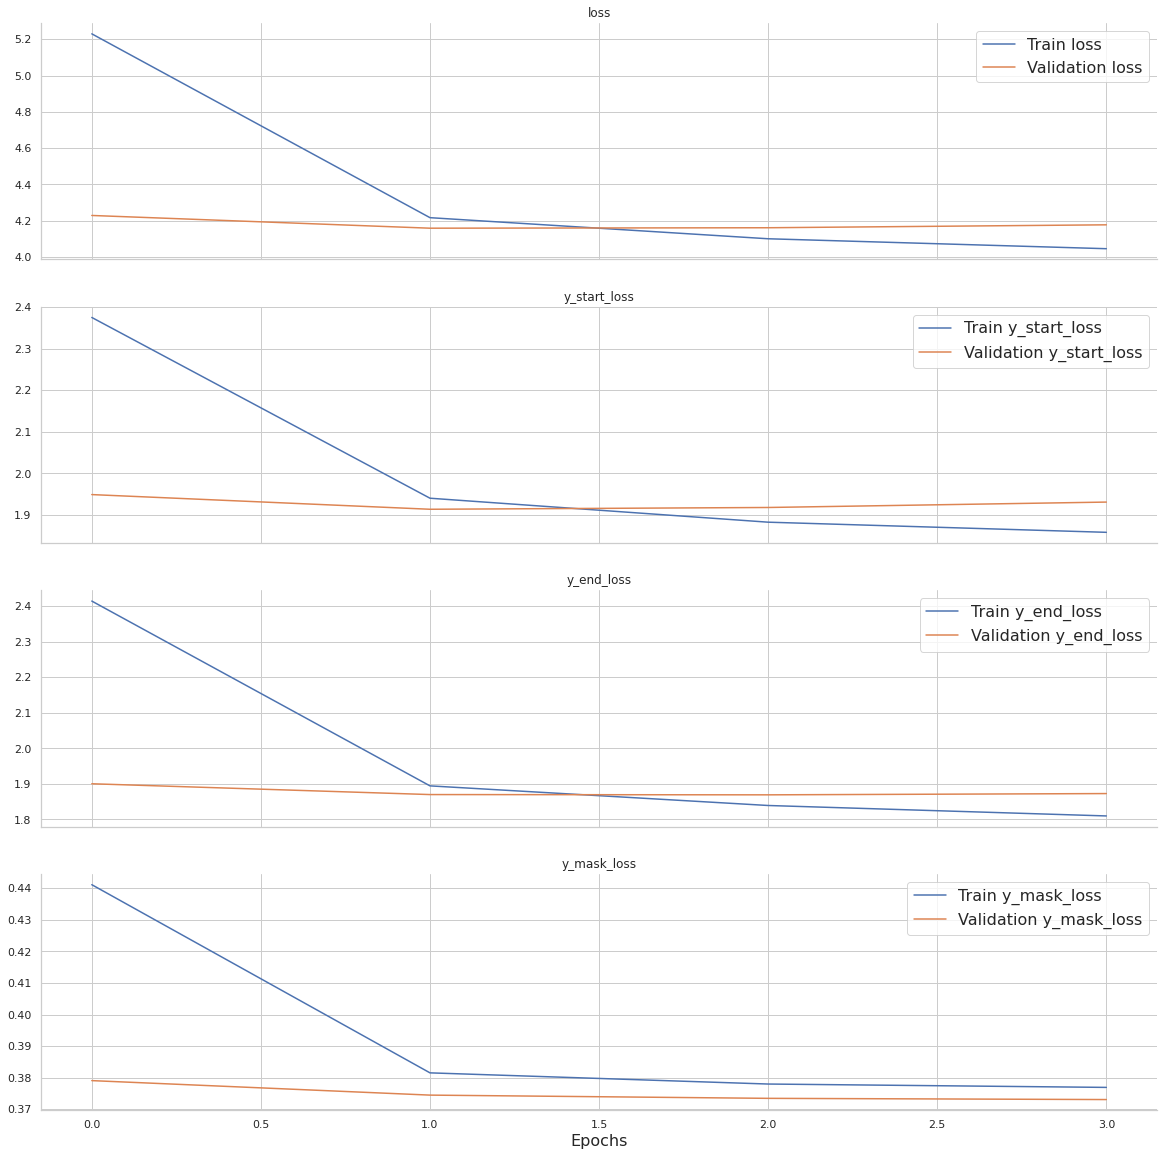

Fold: 3


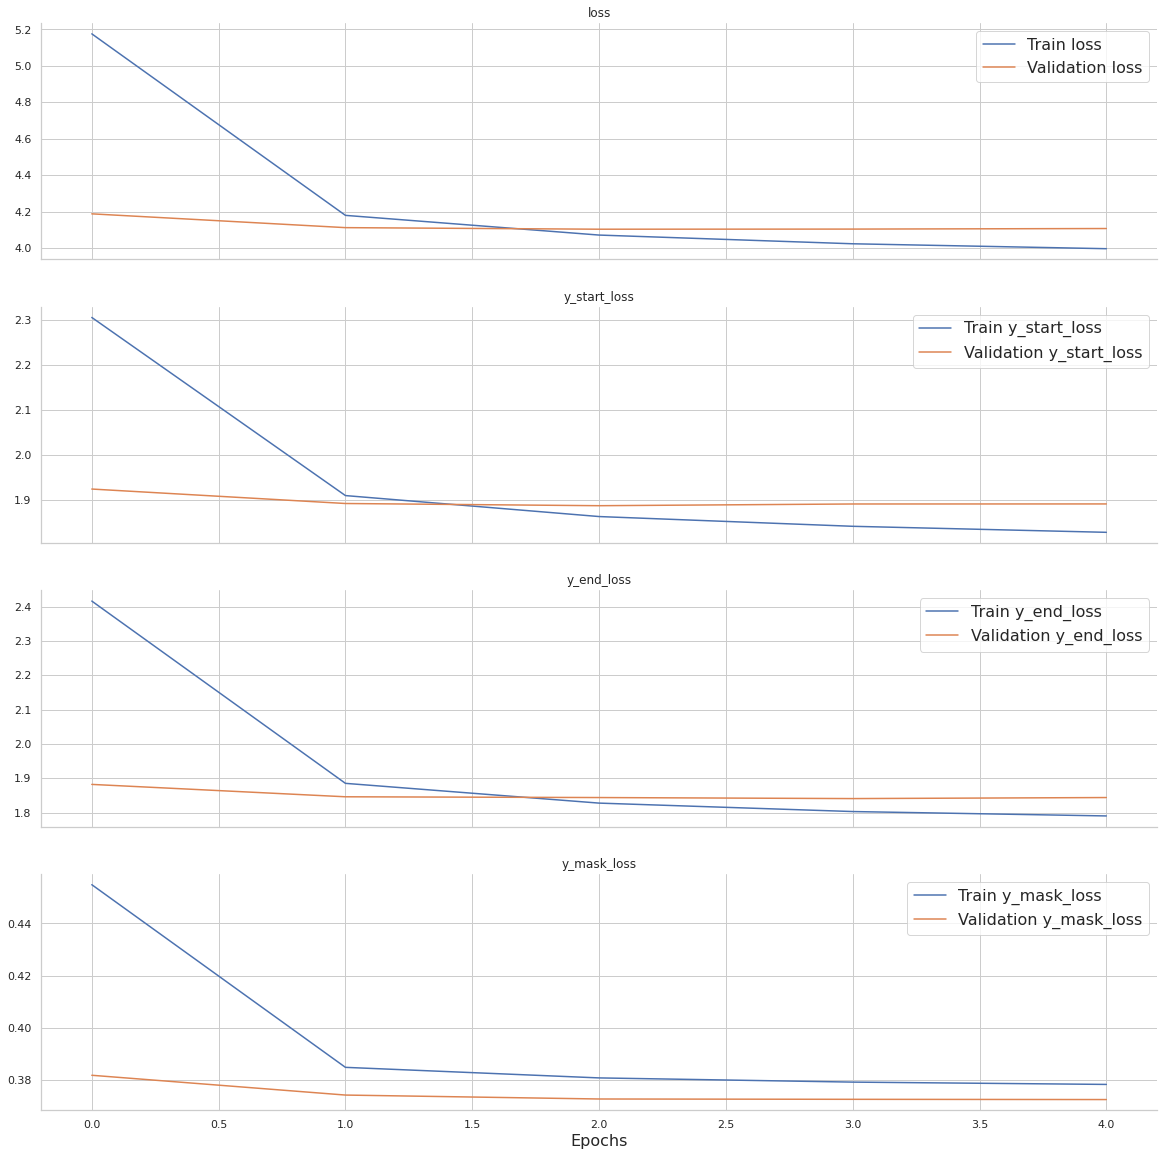

Fold: 4


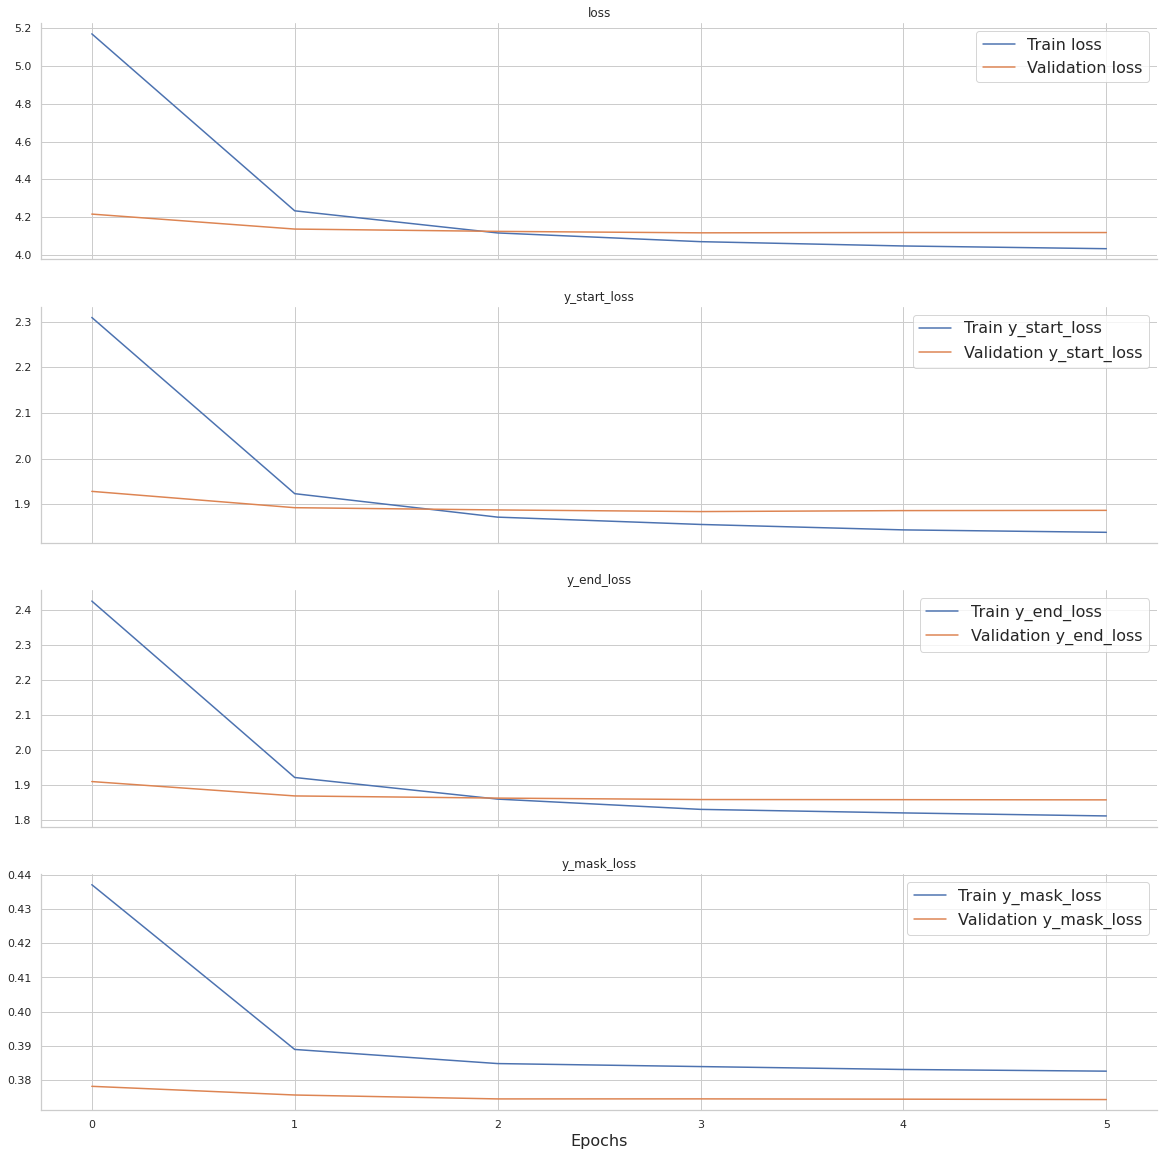

Fold: 5


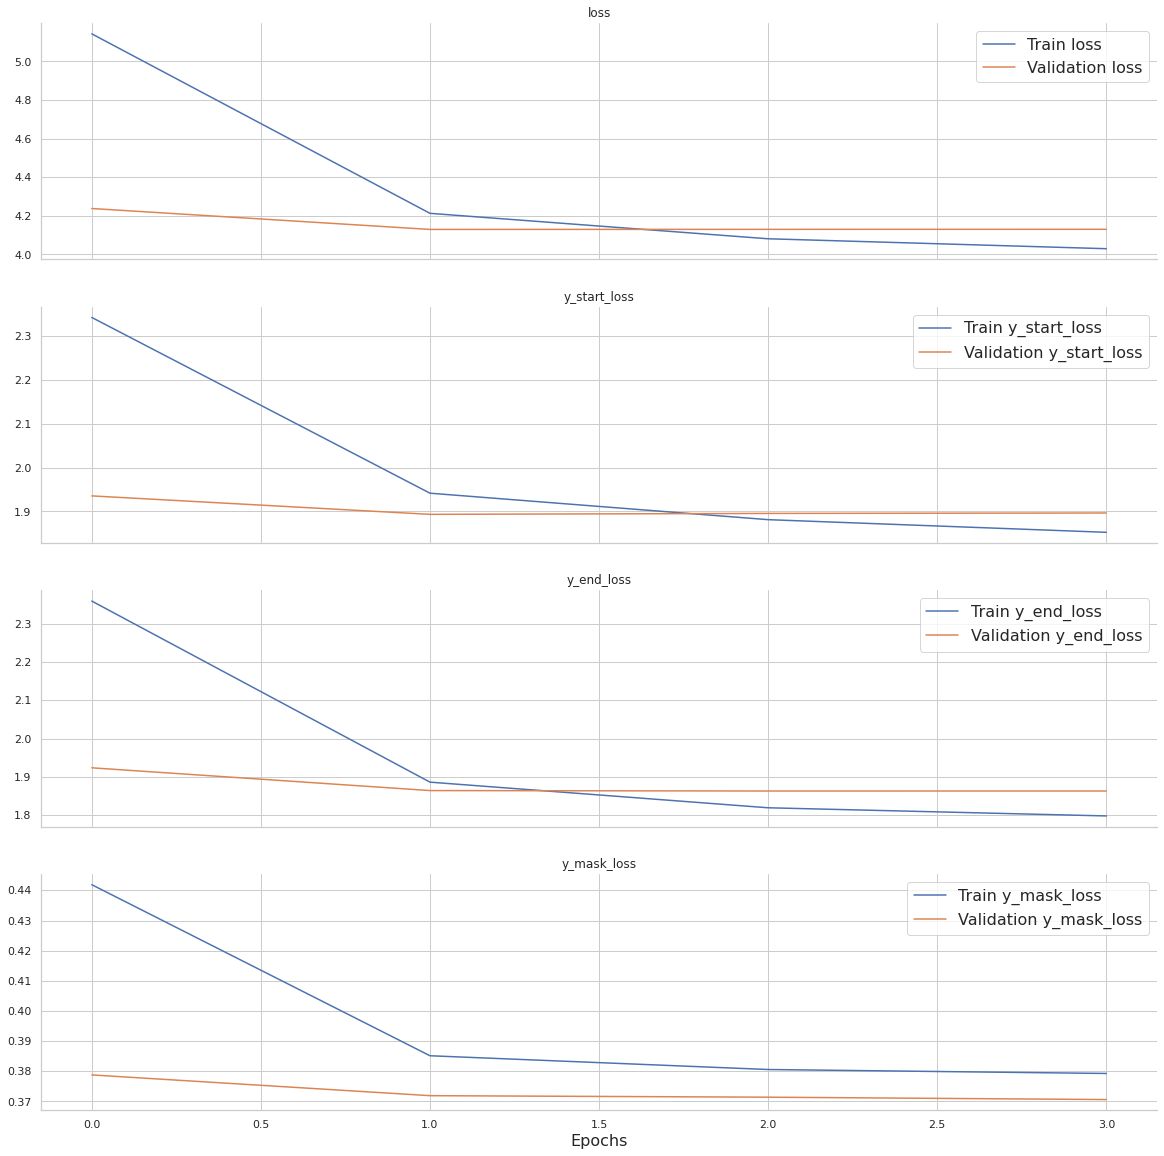

In [10]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [11]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.753132,0.722623,0.030509,0.744855,0.718927,0.747691,0.721762,0.758829,0.722543,0.762068,0.727871,0.752218,0.722010
Sentiment negative,0.602485,0.548202,0.054284,0.593624,0.544439,0.591413,0.543747,0.609945,0.561753,0.619216,0.549720,0.598228,0.541348
Sentiment neutral,0.974968,0.973675,0.001293,0.963980,0.962219,0.977803,0.977203,0.977327,0.974831,0.978049,0.976108,0.977683,0.978015
Sentiment positive,0.592150,0.543995,0.048155,0.588054,0.550675,0.580733,0.540416,0.600714,0.529973,0.601866,0.556455,0.589384,0.542458
0 <= text tokens < 3,0.960451,0.956673,0.003779,0.964444,0.967742,0.967105,0.932203,0.959052,0.972727,0.962719,0.949153,0.948936,0.961538
3 <= text tokens < 15,0.805044,0.782544,0.022500,0.803215,0.785445,0.799287,0.787062,0.810055,0.778856,0.811499,0.781606,0.801164,0.779748
15 <= text tokens < 30,0.722298,0.685810,0.036487,0.709087,0.681804,0.716882,0.677281,0.730653,0.685003,0.732686,0.689501,0.722181,0.695463
30 <= text tokens < 45,0.689184,0.652353,0.036831,0.677368,0.629184,0.685221,0.653160,0.689942,0.663302,0.699700,0.681315,0.693688,0.634804
45 <= text tokens < 120,0.815939,0.775065,0.040874,0.793707,0.900810,0.807780,0.783707,0.843194,0.637434,0.839390,0.847776,0.795625,0.705597


# Visualize predictions

In [12]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,imputed,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,False,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,False,sooo sad,1.000000,sad,0.500000,sad,0.500000,sooo sad,1.000000,sad,0.500000
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,False,bullying me...,0.333333,bullying me...,0.333333,bullying,0.500000,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,False,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,False,"sons of ****,",1.000000,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,False,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,False,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,3,3,False,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,3,3,False,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,False,wow...,0.200000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000,wow...,0.200000,wow... u just became cooler.,1.000000
